**Material parameters for Moresi el al (2014)**

This notebook outlines the material parameterisation used to model the dynamics of continental accretion as shown in Extended Data Figure 2 of [Moresi et al (2014) [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

A number of functions must be defined
1. layer intersects of discretised lithospheric structure, a numpy array with dimensions of length [L]
2. depth, a numpy array with dimensions of length [L]
3. crustal density, rho(depth), a numpy array with dimensions of [M/L^3] 
4. temperature, temperature(depth), a numper array with dimensions of [T]
5. yield strength, yieldStrength(pressure), a numpy array with dimensions of pressure []. Pressure assumed to be lithostatic pressure.
6. softened yield strength, yieldStrength2(pressure), a numpy array with dimensions of pressure []. Pressure assumed to be lithostatic pressure.
7. viscous deformation law?

***Notes***

I can't find details on the following
1. The post-softening function? I've assumed post-softening cohesion and friction are 1/2 the original.
2. The cratonic, transition viscosity maximum in Ex Fig 5c,d
3. The cratonic, transition strength profile in Ex Fig 5c,d
4. The back arc strength profile in Ex Fig 5e from?

In [1]:
import underworld as uw
from underworld import function as fn

import numpy as np
import math
import scipy
import scipy.special as special
import os
import matplotlib.pyplot as pypl
import pint

In [2]:
u = pint.UnitRegistry()

**Define the layer intersections in the modelled lithosphere**

In [3]:
# for oceanic lithosphere, ExFig 5a, 5b
layers = np.array([0, 25, 50, 75, 100, 200]) * 10**3 * u.meter 
# for cratonic lithosphere, ExFig 5c
# layers = np.array([0, 75, 150, 200]) * 10**3 * u.meter 
# for transition, ExFig 5d
# layers = np.array([0, 50, 100, 200]) * 10**3 * u.meter 
# for back arc, ExFig 5e
# layers = np.array([0, 50, 100, 200]) * 10**3 * u.meter 
print('Numer of layers is {}'.format(len(layers)-1))
print('Interface at {}'.format(layers.to('kilometer')))

Numer of layers is 5
Interface at [   0.   25.   50.   75.  100.  200.] kilometer


**Define depth**

In [4]:
res   = 251
depth = np.linspace(0, 250., res) * 10**3 * u.meter

**Define density**

In [5]:
# oceanic lithosphere
crustThickness  = 7.0  * u.kilometer
#crustDensity    = 2900 * u.kilogram / u.meter**3 # Oceanic crust (cold basalt)
crustDensity    = 3400 * u.kilogram / u.meter**3 # Eclogite
#

# # cratonic lithosphere
# crustThickness  = 40.0  * u.kilometer
# crustDensity    = 2700 * u.kilogram / u.meter**3 

# # transition lithosphere
# crustThickness  = 25.0  * u.kilometer
# crustDensity    = 2700 * u.kilogram / u.meter**3 

# # back-arc lithosphere
# crustThickness  = 20.0  * u.kilometer
# crustDensity    = 2800 * u.kilogram / u.meter**3 

mantleDensity   = 3400 * u.kilogram / u.meter**3  # (cold)  
rho = np.ones(res)* u.kilogram / u.meter**3

def density_def(depth):
    for index, y in enumerate(depth):
        if y > crustThickness:
            rho[index] = mantleDensity
        else:
            rho[index] = crustDensity


density_def(depth)

**Define temperature**

In [6]:
Tsurf = 273.15 * u.degK
Tint  = 1573.0 * u.degK
kappa = 1e-6   * u.meter**2 / u.second 
alpha = 3.0e-5 / u.kelvin

grav  = 9.81   * u.meter / u.second**2
R     = 8.314  * u.joule / u.degK / u.mol

# for oceanic lithosphere thickness
def half_space_cooling(depth,age):
    return Tsurf +(Tint-Tsurf) * special.erf(depth/(2*np.sqrt(age*kappa)))

# age of oceanic lithosphere
#age = 120. * 10**6 * u.year
age = 80. * 10**6 * u.year

# temperature profile of oceanic lithosphere
temperature = half_space_cooling(depth.to_base_units(), age.to_base_units())

# # temperature of cratonic lithosphere
# def craton_linear_geotherm(depth):
#     linear = depth.to('kilometer')*(Tint-Tsurf)/(150.*u.kilometer)+Tsurf
#     return np.minimum(linear.magnitude,Tint)*linear.units

# temperature = craton_linear_geotherm(depth)

# # temperature of backarc lithosphere
# def transition_linear_geotherm(depth):
#     linear = depth.to('kilometer')*(Tint-Tsurf)/(100.*u.kilometer)+Tsurf
#     return np.minimum(linear.magnitude,Tint)*linear.units

# temperature = transition_linear_geotherm(depth)

# # temperature of backarc lithosphere
# def backarc_linear_geotherm(depth):
#     linear = depth.to('kilometer')*(Tint-Tsurf)/(80.*u.kilometer)+Tsurf
#     return np.minimum(linear.magnitude,Tint)*linear.units

# temperature = backarc_linear_geotherm(depth)

In [7]:
# density profile of lithosphere
deltaT  = temperature - Tsurf
density = rho - rho * deltaT * alpha

In [8]:
# lithostatic pressure = \rho * g * h
pressure = density * grav * depth

**Define yield criteria**

In [9]:
# # oceanic lithosphere       
cohesion = 12.5 * u.megapascal

friction = 0.0666
cohesion2 = cohesion/2.
friction2 = friction/2.  # is this needed for the oceanic lithosphere?

yieldStrength  = cohesion  + friction  * pressure
yieldStrength2 = cohesion2 + friction2 * pressure # post yeild strength

# # cratonic lithosphere strength profiles
# yieldStrength  = np.ones(res)*130.*u.megapascal
# yieldStrength2 = yieldStrength/2.

# # transitional lithosphere strength profiles
# yieldStrength = np.zeros(res)*u.megapascal
# def trans_yeildStrength(depth):
#     for index, y in enumerate(depth):
#         if y < 50.*u.kilometer:
#             yieldStrength[index] = 40.*u.megapascal
#         elif y < 100.*u.kilometer:
#             yieldStrength[index] = 150.*u.megapascal
#     return yieldStrength

# # yieldStrength  = np.ones(res)*40.*u.megapascal
# trans_yeildStrength(depth)
# yieldStrength2 = yieldStrength/2.


# # back arc weak
# cohesion = 12.5*u.megapascal*2

# friction = 0.0666
# cohesion2 = cohesion/2.
# friction2 = friction/2.  # is this needed for the oceanic lithosphere?

# yieldStrength  = cohesion  + friction  * pressure
# yieldStrength2 = cohesion2 + friction2 * pressure # post yeild strength


**Define viscous deformation**

In [10]:
# wet diffusion creep - Karato & Wu, 1993
A = 5.3  * 10**15 / u.pascal / u.second
E = 240. * 10**3 * u.joule / u.mol
V = 5.0  * 1e-6 * u.meter**3 / u.mol

max_viscosity = 10**5

def arrhenius(T,P):
    """ Arrhenius viscosity assuming absolute temperature T and pressure P """
    #print( E, V, P, R, T)
    # DW should be scaled to 'density' of crust or mantle, not just mantle?
    return np.exp((E + V*P)/(R*T))

In [11]:
# define some reference parameters
ref_depth     = 100. * 10**3 *u.meter   
ref_pressure  = mantleDensity * grav * ref_depth
ref_temp      = Tint
ref_viscosity = arrhenius(ref_temp, ref_pressure)
ref_density   = mantleDensity * (Tint-Tsurf) * alpha

In [12]:
# calculate viscosity profile
viscosity = np.clip(arrhenius(temperature, pressure)/ref_viscosity, a_min = 0, a_max = max_viscosity) 

In [13]:
# calculate averages of layers
avg_depth      = []
avg_temp       = []
avg_density    = []
avg_pressure   = []
avg_viscosity  = []
avg_strength   = []
low_strength   = []
avg_strength2  = []
low_strength2  = []

prevIndex = 0
for i, interface in enumerate(layers):
    if( interface > 250.*u.kilometer):
        break
    index = np.where(depth.magnitude==interface.magnitude)[0][0]
    if depth[index].magnitude > 0.:
        avg_depth.append(    np.average(depth.to('km').magnitude[prevIndex:index]))
        avg_temp.append(     np.average(temperature[prevIndex:index]))
        avg_density.append(( np.average(density[ prevIndex: index])-(density[-1]).magnitude)/ref_density.magnitude)
        avg_pressure.append( np.average(pressure.to('MPa').magnitude[prevIndex:index]))
        avg_viscosity.append(np.average(viscosity.magnitude[prevIndex:index]))
        avg_strength.append( np.average(yieldStrength.to('MPa').magnitude[prevIndex:index]))
        low_strength.append( np.min(yieldStrength.to('MPa').magnitude[prevIndex:index]))
        avg_strength2.append( np.average(yieldStrength2.to('MPa').magnitude[prevIndex:index]))
        low_strength2.append( np.min(yieldStrength2.to('MPa').magnitude[prevIndex:index]))

    prevIndex = index

<BarContainer object of 3 artists>

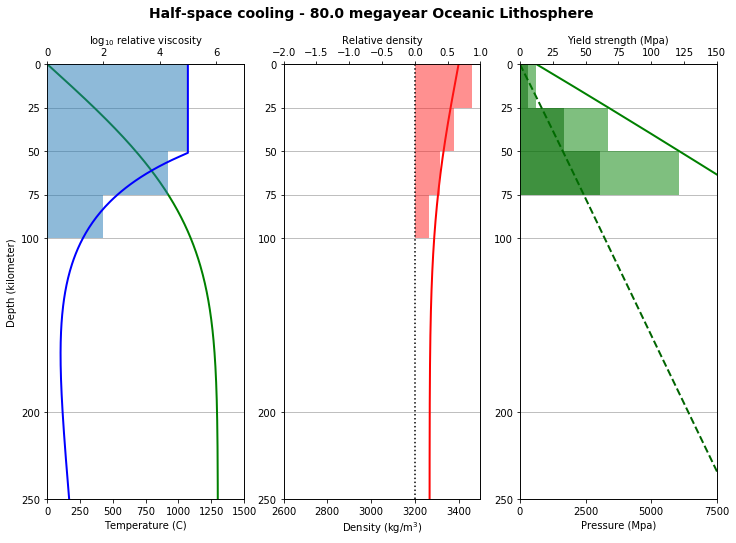

In [14]:
figure1 = pypl.figure(figsize=(12,8))
figure1.suptitle('Half-space cooling - {} Oceanic Lithosphere'.format(age.to('Myear')), fontsize=14, fontweight='bold')

height = (layers.magnitude[2] - layers.magnitude[1])/1e3
# for back arc
#height=((layers.magnitude[1] - layers.magnitude[0])/1e3,(layers.magnitude[2] - layers.magnitude[1])/1e3)

# Temperature and Viscosity profiles
tempPlot = figure1.add_subplot(131)
tempPlot.plot(temperature.to('degC'), depth.to('kilometer'), color='green', linestyle='solid', linewidth=2, label='')
tempPlot.set_xlabel('Temperature (C)')
tempPlot.set_ylabel('Depth (kilometer)')
tempPlot.set_xlim(0,1500)
tempPlot.set_ylim(250, 0)
tempPlot.set_yticks([0,25,50,75,100,200,250])
tempPlot.grid(axis='y')

viscPlot = tempPlot.twiny()
viscPlot.plot(np.log10(viscosity), depth.to('kilometer'), color='blue', linestyle='solid', linewidth=2)
viscPlot.set_xlabel('log$_{10}$ relative viscosity')
viscPlot.set_xlim(0, 7)
viscPlot.set_ylim(0, 250)
viscPlot.invert_yaxis()
viscPlot.barh(layers.magnitude[0:-2]/10**3,np.log10(avg_viscosity[0:-1]), height=height, left=0.0, alpha=0.5, align="edge")
#viscPlot.barh(100.0, np.log10(avg_viscosity[-1]), height=100.0, left=0.0, alpha=0.5, linestyle='solid', hatch='//', align="edge")

# Density profile
densityPlot = figure1.add_subplot(132)
densityPlot.plot(density, depth.to('kilometer'), color='red' , linestyle='solid', linewidth=2)
densityPlot.set_xlabel('Density (kg/m$^3$)')
#densityPlot.set_xlim(2800,3500)
densityPlot.set_xlim(2600,3500)
densityPlot.set_ylim(0, 250)
densityPlot.invert_yaxis()
densityPlot.set_yticks([0,25,50,75,100,200,250])
densityPlot.grid(axis='y')

relDensityPlot = densityPlot.twiny()
relDensityPlot.set_xlabel('Relative density')
#relDensityPlot.set_xlim(-0.2, 1.0)
relDensityPlot.set_xlim(-2., 1.0)
relDensityPlot.axvline(x=0, ymin=0, ymax=1, linestyle='dotted', color='black')
relDensityPlot.set_ylim(250,0)
relDensityPlot.barh(layers[0:-2]/10**3,avg_density[0:-1], height=height, left=0.0, alpha=0.5, color='#FF2222', align="edge")
#relDensityPlot.barh(100.0, avg_density[4], height=100.0, left=0.0, alpha=0.5, fill='false', color='#FF2222', hatch='//', align="edge")

# lithostatic pressure and strength profile
pressurePlot = figure1.add_subplot(133)
pressurePlot.set_xlabel('Pressure (Mpa)')
pressurePlot.set_yticks([0,25,50,75,100,200,250])
pressurePlot.plot(pressure.to('MPa'), depth.to('kilometer'), color='DarkGreen', linestyle='dashed', linewidth=2)
pressurePlot.set_xticks([0,2500,5000,7500,10000])
pressurePlot.set_ylim(0, 250)
pressurePlot.invert_yaxis()
pressurePlot.set_xlim(0, 7500)
pressurePlot.grid(axis='y')

strengthPlot = pressurePlot.twiny()
strengthPlot.set_xlabel('Yield strength (Mpa)')
strengthPlot.set_ylim(250,0)
strengthPlot.set_xlim(0, 150)
strengthPlot.plot(yieldStrength.to('MPa'), depth.to('kilometer'), color='green', linestyle='solid', linewidth=2, label='Yield strength (MPa)')
strengthPlot.barh(layers[0:-3]/10**3, low_strength[0:-2], height=height, left=0.0, alpha=0.5, color='green', align="edge")
strengthPlot.barh(layers[0:-3]/10**3,low_strength2[0:-2], height=height, left=0.0, alpha=0.5, color='darkgreen', align="edge")

## print(layers)

In [15]:
print(avg_viscosity)

[100000.0, 100000.0, 19296.439199637785, 96.408351149480026, 5.0296089702980895]


In [16]:
print(avg_density)

[0.86613894097606037, 0.60399610004020132, 0.38492217595199651, 0.22275100979678633, 0.050587859170972901]


In [17]:
print(avg_strength)

[38.968107537529384, 93.379028350417968, 146.88974958610842, 199.88152967272083, 332.20295255944768]


In [18]:
print(avg_strength2)

[19.484053768764692, 46.689514175208984, 73.444874793054211, 99.940764836360415, 166.10147627972384]
